# Implementation of a Variational Quantum Eigensolver (VQE).

The example shown here is from the paper "Scalable Quantum Simulation of
Molecular Energies" by P.J.J. O'Malley et al. [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860v2)
(Note that only the latest arXiv version contains the correct coefficients of
 the Hamiltonian)

Eq. 2 of the paper shows the functional which one needs to minimize and Eq. 3
shows the coupled cluster ansatz for the trial wavefunction (using the unitary
coupled cluster approach). The Hamiltonian is given in Eq. 1. The coefficients
can be found in Table 1. Note that both the ansatz and the Hamiltonian can be
calculated using FermiLib which is a library for simulating quantum systems
on top of ProjectQ.

In [3]:
pip install projectq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.7/433.7 kB 22.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for projectq: filename=projectq-0.8.0-cp312-cp312-linux_x86_64.whl size=2644597 sha256=ac8c688ab2867ac3f9555825da62679109ff2ca450e070eff642c95512c48678
  Stored in directory: /root/.cache/pip/wheels/2b/d7/5c/fa2f3aa27666e46ef55aa2bfb61752737c1e1e592e485891de
Successfully built projectq


In [4]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X

import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Data from paper (arXiv:1512.06860v2) table 1: R, I, Z0, Z1, Z0Z1, X0X1, Y0Y1
raw_data_table_1 = [
    [0.20,  2.8489, 0.5678, -1.4508, 0.6799, 0.0791, 0.0791],
    [0.25,  2.1868, 0.5449, -1.2870, 0.6719, 0.0798, 0.0798],
    [0.30,  1.7252, 0.5215, -1.1458, 0.6631, 0.0806, 0.0806],
    [0.35,  1.3827, 0.4982, -1.0226, 0.6537, 0.0815, 0.0815],
    [0.40,  1.1182, 0.4754, -0.9145, 0.6438, 0.0825, 0.0825],
    [0.45,  0.9083, 0.4534, -0.8194, 0.6336, 0.0835, 0.0835],
    [0.50,  0.7381, 0.4325, -0.7355, 0.6233, 0.0846, 0.0846],
    [0.55,  0.5979, 0.4125, -0.6612, 0.6129, 0.0858, 0.0858],
    [0.60,  0.4808, 0.3937, -0.5950, 0.6025, 0.0870, 0.0870],
    [0.65,  0.3819, 0.3760, -0.5358, 0.5921, 0.0883, 0.0883],
    [0.70,  0.2976, 0.3593, -0.4826, 0.5818, 0.0896, 0.0896],
    [0.75,  0.2252, 0.3435, -0.4347, 0.5716, 0.0910, 0.0910],
    [0.80,  0.1626, 0.3288, -0.3915, 0.5616, 0.0925, 0.0925],
    [0.85,  0.1083, 0.3149, -0.3523, 0.5518, 0.0939, 0.0939],
    [0.90,  0.0609, 0.3018, -0.3168, 0.5421, 0.0954, 0.0954],
    [0.95,  0.0193, 0.2895, -0.2845, 0.5327, 0.0970, 0.0970],
    [1.00, -0.0172, 0.2779, -0.2550, 0.5235, 0.0986, 0.0986],
    [1.05, -0.0493, 0.2669, -0.2282, 0.5146, 0.1002, 0.1002],
    [1.10, -0.0778, 0.2565, -0.2036, 0.5059, 0.1018, 0.1018],
    [1.15, -0.1029, 0.2467, -0.1810, 0.4974, 0.1034, 0.1034],
    [1.20, -0.1253, 0.2374, -0.1603, 0.4892, 0.1050, 0.1050],
    [1.25, -0.1452, 0.2286, -0.1413, 0.4812, 0.1067, 0.1067],
    [1.30, -0.1629, 0.2203, -0.1238, 0.4735, 0.1083, 0.1083],
    [1.35, -0.1786, 0.2123, -0.1077, 0.4660, 0.1100, 0.1100],
    [1.40, -0.1927, 0.2048, -0.0929, 0.4588, 0.1116, 0.1116],
    [1.45, -0.2053, 0.1976, -0.0792, 0.4518, 0.1133, 0.1133],
    [1.50, -0.2165, 0.1908, -0.0666, 0.4451, 0.1149, 0.1149],
    [1.55, -0.2265, 0.1843, -0.0549, 0.4386, 0.1165, 0.1165],
    [1.60, -0.2355, 0.1782, -0.0442, 0.4323, 0.1181, 0.1181],
    [1.65, -0.2436, 0.1723, -0.0342, 0.4262, 0.1196, 0.1196],
    [1.70, -0.2508, 0.1667, -0.0251, 0.4204, 0.1211, 0.1211],
    [1.75, -0.2573, 0.1615, -0.0166, 0.4148, 0.1226, 0.1226],
    [1.80, -0.2632, 0.1565, -0.0088, 0.4094, 0.1241, 0.1241],
    [1.85, -0.2684, 0.1517, -0.0015, 0.4042, 0.1256, 0.1256],
    [1.90, -0.2731, 0.1472,  0.0052, 0.3992, 0.1270, 0.1270],
    [1.95, -0.2774, 0.1430,  0.0114, 0.3944, 0.1284, 0.1284],
    [2.00, -0.2812, 0.1390,  0.0171, 0.3898, 0.1297, 0.1297],
    [2.05, -0.2847, 0.1352,  0.0223, 0.3853, 0.1310, 0.1310],
    [2.10, -0.2879, 0.1316,  0.0272, 0.3811, 0.1323, 0.1323],
    [2.15, -0.2908, 0.1282,  0.0317, 0.3769, 0.1335, 0.1335],
    [2.20, -0.2934, 0.1251,  0.0359, 0.3730, 0.1347, 0.1347],
    [2.25, -0.2958, 0.1221,  0.0397, 0.3692, 0.1359, 0.1359],
    [2.30, -0.2980, 0.1193,  0.0432, 0.3655, 0.1370, 0.1370],
    [2.35, -0.3000, 0.1167,  0.0465, 0.3620, 0.1381, 0.1381],
    [2.40, -0.3018, 0.1142,  0.0495, 0.3586, 0.1392, 0.1392],
    [2.45, -0.3035, 0.1119,  0.0523, 0.3553, 0.1402, 0.1402],
    [2.50, -0.3051, 0.1098,  0.0549, 0.3521, 0.1412, 0.1412],
    [2.55, -0.3066, 0.1078,  0.0572, 0.3491, 0.1422, 0.1422],
    [2.60, -0.3079, 0.1059,  0.0594, 0.3461, 0.1432, 0.1432],
    [2.65, -0.3092, 0.1042,  0.0614, 0.3433, 0.1441, 0.1441],
    [2.70, -0.3104, 0.1026,  0.0632, 0.3406, 0.1450, 0.1450],
    [2.75, -0.3115, 0.1011,  0.0649, 0.3379, 0.1458, 0.1458],
    [2.80, -0.3125, 0.0997,  0.0665, 0.3354, 0.1467, 0.1467],
    [2.85, -0.3135, 0.0984,  0.0679, 0.3329, 0.1475, 0.1475]]

def variational_quantum_eigensolver(theta, hamiltonian):
    """
    Args:
        theta (float): variational parameter for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the wavefunction for parameter theta
    """
    # Create a ProjectQ compiler with a simulator as a backend
    eng = projectq.MainEngine()
    # Allocate 2 qubits in state |00>
    wavefunction = eng.allocate_qureg(2)
    # Initialize the Hartree Fock state |01>
    X | wavefunction[0]
    # build the operator for ansatz wavefunction
    ansatz_op = QubitOperator('X0 Y1')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(theta, ansatz_op) | wavefunction
    # flush all gates
    eng.flush()
    # Calculate the energy.
    # The simulator can directly return expectation values, while on a
    # real quantum devices one would have to measure each term of the
    # Hamiltonian.
    energy = eng.backend.get_expectation_value(hamiltonian, wavefunction)
    # Measure in order to return to return to a classical state
    # (as otherwise the simulator will give an error)
    All(Measure) | wavefunction
    return energy

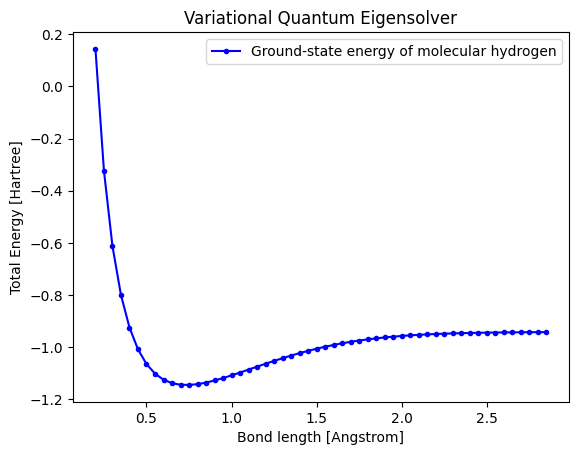

In [5]:
lowest_energies = []
bond_distances = []
for i in range(len(raw_data_table_1)):
    # Use data of paper to construct the Hamiltonian
    bond_distances.append(raw_data_table_1[i][0])
    hamiltonian = raw_data_table_1[i][1] * QubitOperator(())  # == identity
    hamiltonian += raw_data_table_1[i][2] * QubitOperator("Z0")
    hamiltonian += raw_data_table_1[i][3] * QubitOperator("Z1")
    hamiltonian += raw_data_table_1[i][4] * QubitOperator("Z0 Z1")
    hamiltonian += raw_data_table_1[i][5] * QubitOperator("X0 X1")
    hamiltonian += raw_data_table_1[i][6] * QubitOperator("Y0 Y1")

    # Use Scipy to perform the classical outerloop of the variational
    # eigensolver, i.e., the minimization of the parameter theta.
    # See documentation of Scipy for different optimizers.
    minimum = minimize_scalar(lambda theta: variational_quantum_eigensolver(theta, hamiltonian))
    lowest_energies.append(minimum.fun)

# print result
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Variational Quantum Eigensolver")
plt.plot(bond_distances, lowest_energies, "b.-",
         label="Ground-state energy of molecular hydrogen")
plt.legend()
plt.show()